## Imports

In [1]:
# !git clone https://github.com/facebookresearch/detr.git

In [1]:
import matplotlib.pyplot as plt
from PIL import Image
import IPython.display as ipd
import os
import numpy as np
import pandas as pd
from datetime import datetime
import time
import random
from tqdm import tqdm


#Torch
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.utils.data.sampler import SequentialSampler, RandomSampler
import torchvision
import torchvision.transforms as transforms

#sklearn
from sklearn.model_selection import StratifiedKFold

#CV
import cv2

################# DETR FUCNTIONS FOR LOSS########################
import sys
sys.path.append('./detr/')

from detr.models.matcher import HungarianMatcher
from detr.models.detr import SetCriterion
#################################################################

#Albumenatations
import albumentations as A
import matplotlib.pyplot as plt
from albumentations.pytorch.transforms import ToTensorV2

#Glob
from glob import glob

from iterstrat.ml_stratifiers import MultilabelStratifiedShuffleSplit

In [2]:
print(A.__version__) 

1.3.1


In [3]:
# import torch
# torch.backends.cudnn.enabled = True
# torch.backends.cudnn.benchmark = False

## Utils

In [4]:
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count

## Config

In [5]:
n_folds = 5
seed = 42
num_classes = 11
num_queries = 65 #changed from 100
null_class_coef = 0.5
BATCH_SIZE = 8
LR = 2e-5
EPOCHS = 2
device = torch.device('cuda')

label_to_idx = {'car': 0,
               'pedestrian': 1,
               'truck': 2,
               'bus': 3,
               'bicycle': 4,
               'rider': 5,
               'other vehicle': 6,
               'motorcycle': 7,
               'other person': 8,
               'trailer': 9,
               'train': 10}

idx_to_label = {0: 'car',
               1: 'pedestrian',
               2: 'truck',
               3: 'bus',
               4: 'bicycle',
               5: 'rider',
               6: 'other vehicle',
               7: 'motorcycle',
               8: 'other person',
               9: 'trailer',
               10: 'train'}

color_map = {
    "car": (0, 0, 255),
    "truck": (0, 0, 100),
    "pedestrian": (255, 0, 0),
    "other vehicle": (0, 0, 150),
    "rider": (200, 100, 0),
    "bicycle": (0, 255, 0),
    "other person": (200, 0, 0),
    "trailer": (0, 150, 150),
    "motorcycle": (0, 150, 0),
    "bus": (0, 0, 100),
    "train": (0, 0, 100)
}

## Seed

In [6]:
def seed_everything(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

seed_everything(seed)

## Data Preparation

In [7]:
df = pd.read_csv('mot_labels.csv')
df['x'] = df['box2d.x1']
df['y'] = df['box2d.y1']
df['w'] = df['box2d.x2'] - df['box2d.x1']
df['h'] = df['box2d.y2'] - df['box2d.y1']
df = df[df['haveVideo'] == True].copy()
df.dropna(inplace=True)
df.head()

/home/ubuntu/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3049: DtypeWarning: Columns (5,6,7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,name,videoName,frameIndex,id,category,attributes.crowd,attributes.occluded,attributes.truncated,box2d.x1,box2d.x2,box2d.y1,box2d.y2,haveVideo,x,y,w,h
0,01c71072-718028b8-0000001.jpg,01c71072-718028b8,0,89537.0,car,False,True,False,825.173210,1003.094688,355.011547,418.198614,True,825.173210,355.011547,177.921478,63.187067
1,01c71072-718028b8-0000001.jpg,01c71072-718028b8,0,89538.0,car,False,True,False,484.295612,700.461894,346.697460,424.849885,True,484.295612,346.697460,216.166282,78.152425
2,01c71072-718028b8-0000001.jpg,01c71072-718028b8,0,89539.0,pedestrian,False,True,False,645.588915,663.879908,338.383372,358.337182,True,645.588915,338.383372,18.290993,19.953811
3,01c71072-718028b8-0000001.jpg,01c71072-718028b8,0,89540.0,car,False,False,False,120.969977,192.471132,359.168591,409.053118,True,120.969977,359.168591,71.501155,49.884527
4,01c71072-718028b8-0000001.jpg,01c71072-718028b8,0,89541.0,car,False,False,False,251.501155,315.519630,354.180139,400.739030,True,251.501155,354.180139,64.018476,46.558891


In [8]:
jpegs = os.listdir('frames_v2')
df_cleaned = df[df['name'].isin(jpegs)].copy()

In [9]:
len(jpegs)

189580

### Train Test Split (if not done yet, otherwise import text file)

In [18]:
resampling = False

In [19]:
if resampling:
    videos = list(df_cleaned['videoName'].drop_duplicates())
    video_subset = random.sample(videos, 100)
    
    df_subset = df_cleaned[df_cleaned['videoName'].isin(video_subset)]
    
    class_counts = df_subset.groupby(['videoName', 'category']).size().unstack(fill_value=0)
    class_counts.reset_index(inplace=True)

In [20]:
# easy_videos = [
#     '003e23ee-67d25f19',
#     '012a9c41-cef5b320',
#     '00091078-59817bb0',
#     '003baca5-aab2e274',
#     '011aeca1-fe5af665'
# ]

In [21]:
if resampling:
    # Extract features and labels
    X = class_counts['videoName'].values.reshape(-1, 1)  # Features are just the video IDs
    y = class_counts.iloc[:, 1:].values  # Labels are the counts of each object class

    # Initialize the multi-label stratified shuffle splitter
    # Set test_size to the desired proportion, e.g., 0.2 for 20%
    msss = MultilabelStratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

    # Perform the split
    train_fold_idx_list = []
    test_fold_idx_list = []
    for train_index, test_index in msss.split(X, y):
        # Split the dataframe into train and test sets based on the indices
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]

In [22]:
if resampling:
    X_train_list = [videoName[0] for videoName in X_train]
    X_test_list = [videoName[0] for videoName in X_test]
    counts_train_df = class_counts[class_counts['videoName'].isin(X_train_list)]
    counts_test_df = class_counts[class_counts['videoName'].isin(X_test_list)]
    train_counts_df = pd.merge(df, counts_train_df, on='videoName')
    test_counts_df = pd.merge(df, counts_test_df, on='videoName')

    labels = df['category'].dropna().unique()
    train_class_distribution = train_counts_df[labels].sum().sort_index()
    test_class_distribution = test_counts_df[labels].sum().sort_index()

    print('Train Class Distribution:')
    print(train_class_distribution)
    print('-' * 30)
    print('Test Class Distribution:')
    print(test_class_distribution)

In [23]:
if resampling:
    train_class_distribution = train_counts_df['category'].value_counts(normalize=True)
    test_class_distribution = test_counts_df['category'].value_counts(normalize=True)

    # Create a DataFrame to compare the distributions
    comparison_df = pd.DataFrame({
        'Train Distribution': train_class_distribution,
        'Test Distribution': test_class_distribution
    })

    print(comparison_df)

In [24]:
if resampling:
    print(len(X_train_list), len(X_test_list))

In [25]:
if resampling:
    train_series = pd.Series(X_train_list)
    test_series = pd.Series(X_test_list)

    train_series.to_csv('train_videos_small.csv')
    test_series.to_csv('test_videos_small.csv')

### Train Test Split Import

In [10]:
X_train_df = pd.read_csv('train_videos_small.csv', header = None, index_col = 0)
X_test_df = pd.read_csv('test_videos_small.csv', header = None, index_col = 0)

X_train_list = list(X_train_df[1])
X_test_list = list(X_test_df[1])

len(X_train_list), len(X_test_list)

(80, 20)

In [11]:
train_df = df_cleaned[df_cleaned['videoName'].isin(X_train_list)].copy()
test_df = df_cleaned[df_cleaned['videoName'].isin(X_test_list)].copy()

In [12]:
train_df.head()

,name,videoName,frameIndex,id,category,attributes.crowd,attributes.occluded,attributes.truncated,box2d.x1,box2d.x2,box2d.y1,box2d.y2,haveVideo,x,y,w,h
20945,006a7635-c42f9f97-0000002.jpg,006a7635-c42f9f97,1,60697.0,car,False,False,False,490.634731,714.826347,347.497006,525.125749,True,490.634731,347.497006,224.191617,177.628743
20946,006a7635-c42f9f97-0000002.jpg,006a7635-c42f9f97,1,60698.0,car,False,False,True,1097.676647,1279.616766,323.353293,538.059880,True,1097.676647,323.353293,181.940120,214.706587
20947,006a7635-c42f9f97-0000002.jpg,006a7635-c42f9f97,1,60699.0,car,False,True,False,945.916168,1164.934132,365.604790,494.083832,True,945.916168,365.604790,219.017964,128.479042
20948,006a7635-c42f9f97-0000002.jpg,006a7635-c42f9f97,1,60700.0,car,False,True,False,852.790419,1005.413174,350.946108,453.556886,True,852.790419,350.946108,152.622754,102.610778
20949,006a7635-c42f9f97-0000002.jpg,006a7635-c42f9f97,1,60701.0,car,False,True,False,819.161677,896.766467,355.257485,433.724551,True,819.161677,355.257485,77.604790,78.467066


In [13]:
# THIS IS WRONG-IGNORE FOR NOW
# easy_videos = [
#     '003e23ee-67d25f19',
#     '012a9c41-cef5b320',
#     '00091078-59817bb0',
#     '003baca5-aab2e274',
#     '011aeca1-fe5af665'
# ]

In [14]:
train_df.isna().sum()

name                    0
videoName               0
frameIndex              0
id                      0
category                0
attributes.crowd        0
attributes.occluded     0
attributes.truncated    0
box2d.x1                0
box2d.x2                0
box2d.y1                0
box2d.y2                0
haveVideo               0
x                       0
y                       0
w                       0
h                       0
dtype: int64

In [15]:
test_df.isna().sum()

name                    0
videoName               0
frameIndex              0
id                      0
category                0
attributes.crowd        0
attributes.occluded     0
attributes.truncated    0
box2d.x1                0
box2d.x2                0
box2d.y1                0
box2d.y2                0
haveVideo               0
x                       0
y                       0
w                       0
h                       0
dtype: int64

## Augmentations

In [16]:
def get_train_transforms():
    return A.Compose([A.OneOf([A.HueSaturationValue(hue_shift_limit=0.2, sat_shift_limit= 0.2, val_shift_limit=0.2, p=0.9),

                      A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.9)],p=0.9),

                      A.ToGray(p=0.01),

                      A.HorizontalFlip(p=0.5),
                      
                      #A.augmentations.geometric.resize.LongestMaxSize(max_size=64, p=1),

                      #A.Resize(height=512, width=512, p=0), #changed to p=0 from p=1 to get rid of it

                      #A.Cutout(num_holes=8, max_h_size=64, max_w_size=64, fill_value=0, p=0.5),

                      ToTensorV2(p=1.0)],

                      p=1.0,

                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

def get_valid_transforms():
    return A.Compose([A.Resize(height=512, width=512, p=0),
                      ToTensorV2(p=1.0)],
                      p=1.0,
                      bbox_params=A.BboxParams(format='coco',min_area=0, min_visibility=0,label_fields=['labels'])
                      )

## Creating a Dataset Class

In [17]:
DIR_TRAIN = 'frames_v2'

class DrivingDataset(Dataset):
    def __init__(self,image_ids,dataframe,transforms=None):
        self.image_ids = image_ids
        self.df = dataframe
        self.transforms = transforms
        self.label_map = {'car': 0,
                       'pedestrian': 1,
                       'truck': 2,
                       'bus': 3,
                       'bicycle': 4,
                       'rider': 5,
                       'other vehicle': 6,
                       'motorcycle': 7,
                       'other person': 8,
                       'trailer': 9,
                       'train': 10}

    def __len__(self) -> int:
        return self.image_ids.shape[0]

    def __getitem__(self,index):
        image_id = self.image_ids[index]
        records = self.df[self.df['name'] == image_id]

        image = cv2.imread(f'{DIR_TRAIN}/{image_id}', cv2.IMREAD_COLOR).astype(np.float32)
#         image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)
        image /= 255.0

        # DETR takes in data in coco format
        boxes = records[['x', 'y', 'w', 'h']].values

        #Area of bb
        area = boxes[:,2]*boxes[:,3]
        area = torch.as_tensor(area, dtype=torch.float32)

        # AS pointed out by PRVI It works better if the main class is labelled as zero
        labels = records['category'].values
        labels =  np.array([self.label_map[label] for label in labels], dtype=np.int32)


        if self.transforms:
            sample = {
                'image': image,
                'bboxes': boxes,
                'labels': labels
            }
            sample = self.transforms(**sample)
            image = sample['image']
            boxes = sample['bboxes']
            labels = sample['labels']


        #Normalizing BBOXES

        _,h,w = image.shape
        boxes = A.core.bbox_utils.normalize_bboxes(sample['bboxes'],rows=h,cols=w)
        target = {}
        target['boxes'] = torch.as_tensor(boxes,dtype=torch.float32)
        target['labels'] = torch.as_tensor(labels,dtype=torch.long)
        target['image_id'] = torch.tensor([index])
        target['area'] = area

        return image, target, image_id

In [18]:
def collate_fn(batch):
    return tuple(zip(*batch))

# train_dataset = DrivingDataset(image_ids=train_df.name.values, 
#                                dataframe=train_df, 
#                                transforms=get_train_transforms())

# train_data_loader = DataLoader(train_dataset, 
#                                batch_size=BATCH_SIZE, 
#                                shuffle=False, 
#                                #num_workers=4, 
#                                collate_fn= collate_fn)

## Model

In [19]:
class DETRModel(nn.Module):
    def __init__(self,num_classes,num_queries):
        super(DETRModel,self).__init__()
        self.num_classes = num_classes
        self.num_queries = num_queries

        self.model = torch.hub.load('facebookresearch/detr', 'detr_resnet50', pretrained=True)
        self.in_features = self.model.class_embed.in_features

        self.model.class_embed = nn.Linear(in_features=self.in_features,out_features=self.num_classes)
        self.model.num_queries = self.num_queries

    def forward(self,images):
        return self.model(images)

## Matching and Bipartite Loss

In [20]:
'''
code taken from github repo detr , 'code present in engine.py'
'''

matcher = HungarianMatcher()

weight_dict = weight_dict = {'loss_ce': 1, 'loss_bbox': 1 , 'loss_giou': 1}

losses = ['labels', 'boxes', 'cardinality']

## Training

In [21]:
import sys

def train_fn(data_loader,model,criterion,optimizer,device,scheduler,epoch):
    model.train()
    criterion.train()

    summary_loss = AverageMeter()
    loss_per_batch = []

    tk0 = tqdm(data_loader, total=len(data_loader))

    for step, (images, targets, image_ids) in enumerate(tk0):

        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]


        output = model(images)

        loss_dict = criterion(output, targets)
        weight_dict = criterion.weight_dict

        losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

        optimizer.zero_grad()

        losses.backward()
        optimizer.step()
        if scheduler is not None:
            scheduler.step()

        summary_loss.update(losses.item(),BATCH_SIZE)
        loss_per_batch.append(summary_loss.avg)
        tk0.set_postfix(loss=summary_loss.avg)
        
        torch.cuda.empty_cache()
        del loss_dict, losses

    return summary_loss, loss_per_batch

## Eval

In [22]:
def eval_fn(data_loader, model,criterion, device):
    model.eval()
    criterion.eval()
    summary_loss = AverageMeter()

    with torch.no_grad():

        tk0 = tqdm(data_loader, total=len(data_loader))
        for step, (images, targets, image_ids) in enumerate(tk0):

            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            output = model(images)

            loss_dict = criterion(output, targets)
            weight_dict = criterion.weight_dict

            losses = sum(loss_dict[k] * weight_dict[k] for k in loss_dict.keys() if k in weight_dict)

            summary_loss.update(losses.item(),BATCH_SIZE)
            tk0.set_postfix(loss=summary_loss.avg)
            
            torch.cuda.empty_cache()
            del loss_dict, losses
            
    return summary_loss

## Testing / exploring

In [39]:
# train_dataset = DrivingDataset(image_ids=train_df.name.values, 
#                                dataframe=train_df, 
#                                transforms=get_train_transforms())

# train_data_loader = DataLoader(train_dataset, 
#                                batch_size=BATCH_SIZE, 
#                                    shuffle=True, #False, 
#                                    #num_workers=4, 
#                                    collate_fn= collate_fn)

In [40]:
# def visualize_batch(data_loader):
#     images, targets, image_ids = next(iter(data_loader))
#     fig, ax = plt.subplots(1, 4, figsize=(20, 5))
#     print(image_ids)
#     for i in range(4):
#         img = images[i].numpy().transpose(1, 2, 0)
#         print(img.shape)
#         ax[i].imshow(img)
#         ax[i].axis('off')
#     plt.show()
    
# visualize_batch(train_data_loader)

In [41]:
# img = cv2.imread('frames_v2/018bf09d-cd788942-0000085.jpg')
# print(img.shape)
# plt.imshow(img)

In [42]:
# img_rs = cv2.resize(img, (128, 72))
# plt.imshow(img_rs)

## Pre-trained DETR

### Viewing Sample Images with Bounding Boxes from Pre-trained DETR

In [43]:
def view_sample(df,model,device):
    '''
    Code taken from Peter's Kernel
    https://www.kaggle.com/pestipeti/pytorch-starter-fasterrcnn-train
    '''
    dataset = DrivingDataset(image_ids=df.name.values, 
                            dataframe=df, 
                            transforms=get_valid_transforms())

    data_loader = DataLoader(dataset, 
                            batch_size=BATCH_SIZE, 
                            shuffle=True, #False, 
                            #num_workers=4, 
                            collate_fn= collate_fn)

    images, targets, image_ids = next(iter(data_loader))
    _,h,w = images[0].shape # for de normalizing images

    images = list(img.to(device) for img in images)
    targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

    boxes = targets[0]['boxes'].cpu().numpy()
    boxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(boxes,h,w)]
    sample = images[0].permute(1,2,0).cpu().numpy()
    
#     sample = cv2.cvtColor(sample, cv2.COLOR_RGB2BGR).astype(np.float32)

    model.eval()
    model.to(device)
    cpu_device = torch.device("cpu")

    with torch.no_grad():
        outputs = model(images)

    outputs = [{k: v.to(cpu_device) for k, v in outputs.items()}]

    fig, ax = plt.subplots(1, 1, figsize=(16, 8))

    for box in boxes:
        cv2.rectangle(sample,
                  (box[0], box[1]),
                  (box[2]+box[0], box[3]+box[1]),
                  (220, 0, 0), 1)


    oboxes = outputs[0]['pred_boxes'][0].detach().cpu().numpy()
    oboxes = [np.array(box).astype(np.int32) for box in A.core.bbox_utils.denormalize_bboxes(oboxes,h,w)]
    logits = outputs[0]['pred_logits'][0].detach().cpu().numpy()
    
    for box, logit in zip(oboxes, logits):
        prob = torch.softmax(torch.from_numpy(logit), dim=0).numpy()
        class_idx = np.argmax(prob[:-1])  # Exclude the last class (no-object)
        p = prob[class_idx]
        max_p = 0
        if p > max_p:
            max_p = p
        
        if p > 0.4: 
            label = idx_to_label[class_idx]
            cv2.rectangle(sample,
                          (box[0], box[1]),
                          (box[2] + box[0], box[3] + box[1]),
                          (0, 0, 255), 1)
            cv2.putText(sample, label, (box[0], box[1] - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1)

    ax.set_axis_off()
    ax.imshow(sample)
    plt.show()
    
    print(max_p)

Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_detr_master
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


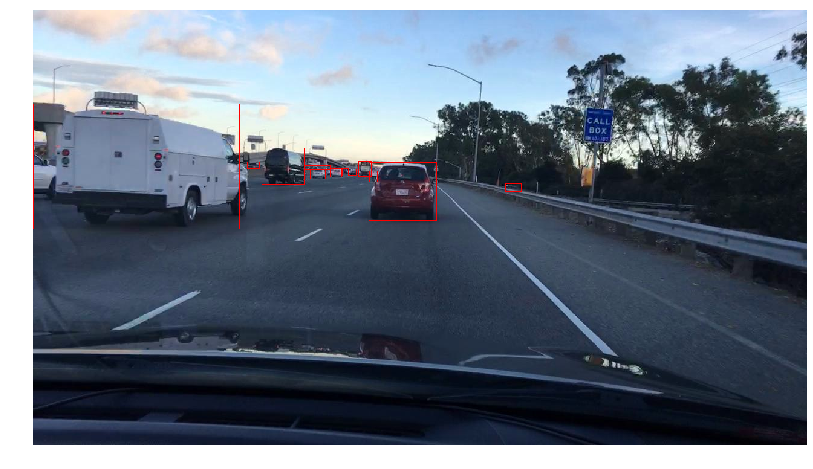

0.17917994


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


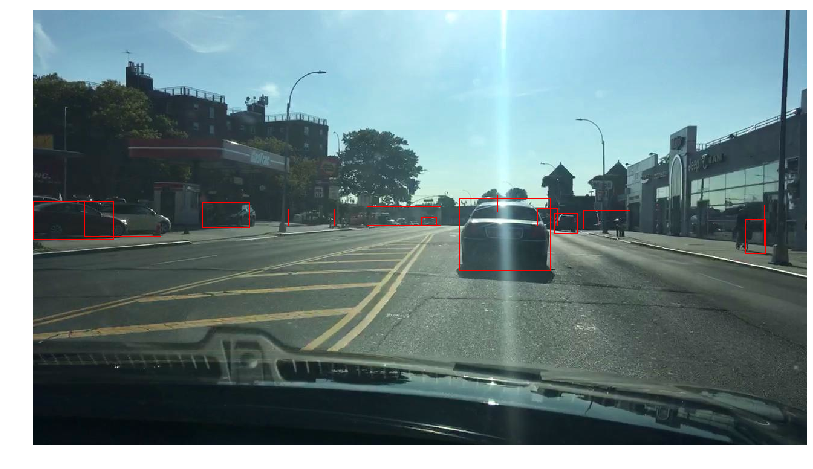

0.2320048


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


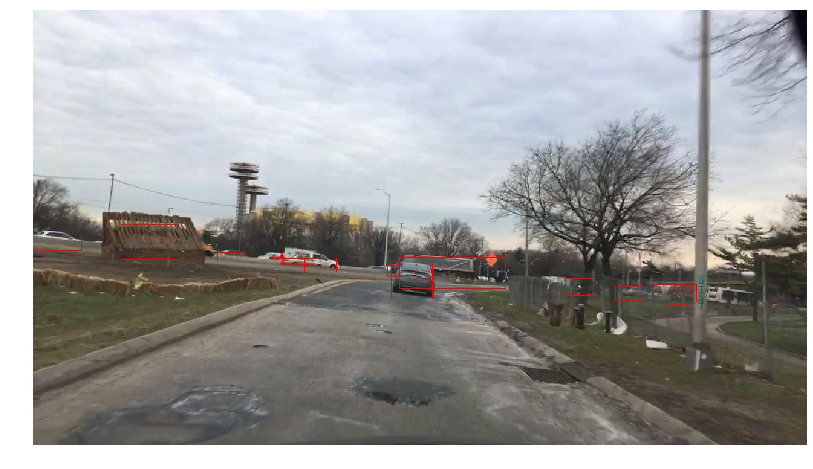

0.18601021


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


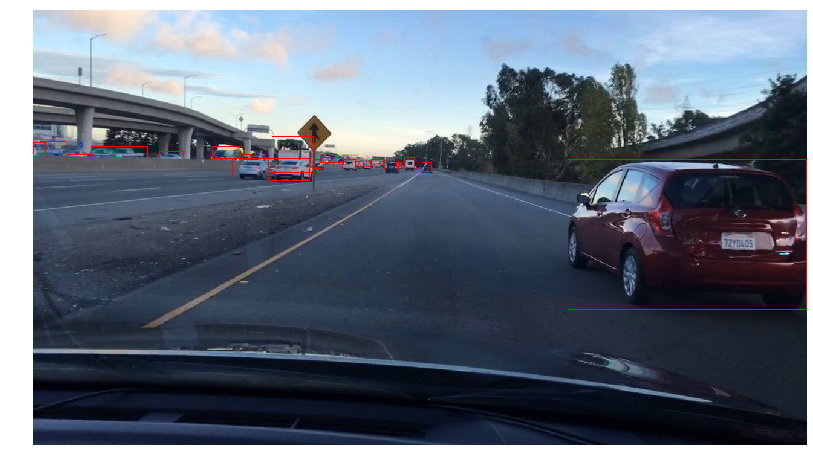

0.16637196


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


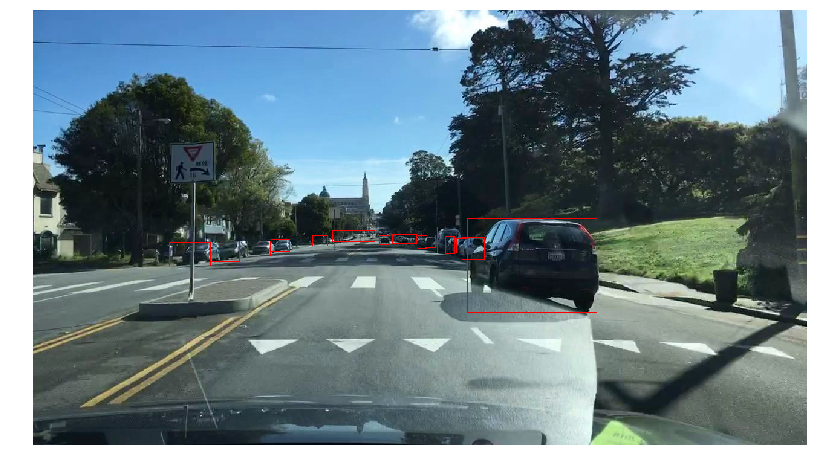

0.14905299


In [247]:
device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)

for i in range(5):
    view_sample(test_df, model, device)

### Performance of Test Set on Pre-Trained DETR

In [ ]:
test_dataset = DrivingDataset(image_ids=test_df.name.values, 
                              dataframe=test_df,
                              transforms=get_valid_transforms())

test_data_loader = DataLoader(test_dataset, 
                               batch_size=64, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

print('test data loader made')


device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses) #changed from num_classes-1 to num_classes
criterion = criterion.to(device)

valid_loss = eval_fn(test_data_loader, model,criterion, device)

In [48]:
print(f'Test loss on the pre-trained DETR: {valid_loss.avg}')

Test loss on the pre-trained DETR: 2.7477256315352334


## Engine

In [23]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


train_dataset = DrivingDataset(image_ids=train_df.name.values, 
                               dataframe=train_df, 
                               transforms=get_train_transforms())

train_data_loader = DataLoader(train_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

print('train data loader made')

test_dataset = DrivingDataset(image_ids=test_df.name.values, 
                              dataframe=test_df,
                              transforms=get_valid_transforms())

test_data_loader = DataLoader(test_dataset, 
                               batch_size=BATCH_SIZE, 
                               shuffle=True, #False, 
                               #num_workers=4, 
                               collate_fn= collate_fn)

print('test data loader made')


device = torch.device('cuda')
model = DETRModel(num_classes=num_classes,num_queries=num_queries)
model = model.to(device)
criterion = SetCriterion(num_classes-1, matcher, weight_dict, eos_coef = null_class_coef, losses=losses) #changed from num_classes-1 to num_classes
criterion = criterion.to(device)


optimizer = torch.optim.AdamW(model.parameters(), lr=LR)

best_loss = 10**5
train_losses = []
test_losses = []
train_batch_losses = []
for epoch in range(EPOCHS):
    train_loss, loss_by_batch = train_fn(train_data_loader, model,criterion, optimizer,device,scheduler=None,epoch=epoch)
    valid_loss = eval_fn(test_data_loader, model,criterion, device)

    print('|EPOCH {}| TRAIN_LOSS {}| VALID_LOSS {}|'.format(epoch+1,train_loss.avg,valid_loss.avg))

    train_losses.append(train_loss.avg)
    train_batch_losses.append(loss_by_batch)
    test_losses.append(valid_loss.avg)

#         if valid_loss.avg < best_loss:
#             best_loss = valid_loss.avg
#             print('Best model found for Fold {} in Epoch {}........Saving Model'.format(fold,epoch+1))
#             torch.save(model.state_dict(), f'detr_best_{fold}.pth')

train data loader made
test data loader made


Using cache found in /home/ubuntu/.cache/torch/hub/facebookresearch_detr_master
  0%|          | 64/18862 [01:04<5:02:18,  1.04it/s, loss=1.84]

KeyboardInterrupt: 

In [55]:
!nvidia-smi

Sat Dec 16 00:57:30 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A10G         On   | 00000000:00:1E.0 Off |                    0 |
|  0%   27C    P0    59W / 300W |  22476MiB / 23028MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
if torch.cuda.device_count() > 1:
    print("Using", torch.cuda.device_count(), "GPUs!")
    # Wrap the model with nn.DataParallel
    model = nn.DataParallel(model)

In [ ]:
torch.cuda.device_count()

In [ ]:
import torch

# Check if CUDA (GPU support) is available
if torch.cuda.is_available():
    print("CUDA is available. GPUs detected: ", torch.cuda.device_count())
    for i in range(torch.cuda.device_count()):
        print(f"Device {i}: {torch.cuda.get_device_name(i)}")
        print(f"  Total Memory: {torch.cuda.get_device_properties(i).total_memory / 1e9} GB")
else:
    print("CUDA is not available.")


In [ ]:
import torch; print(torch.__version__)

In [ ]:
import torch; print(torch.version.cuda)

In [ ]:
print("cuDNN Version:", torch.backends.cudnn.version())

In [ ]:
torch.cuda.memory_allocated(), torch.cuda.max_memory_allocated(), torch.cuda.memory_reserved(), torch.cuda.max_memory_reserved() 